# Introduction 

This notebook runs the ICETEA framework. It contains the Feature Extractor and Data Simulation components. Some steps can be time-consuming and might require GPUs for better time performance. 

We adopt the EyePACS[1] dataset, available [here](https://www.kaggle.com/competitions/diabetic-retinopathy-detection/data). The required files are: 
- sample.zip
- train.zip.001-005
- trainLabels.csv 

Please, remember to cite the original contributors of this dataset. The dataset in the png format has around ~38 GB and ~25 GB after being converted to TFRecords. 

If running on Google Colab, we recommend saving this dataset on Google Drive. 


[1] Cuadros J, Bresnick G. EyePACS: An Adaptable Telemedicine System for Diabetic Retinopathy Screening. Journal of diabetes science and technology (Online). 2009;3(3):509-516.


# Imports

In [1]:

!git clone --branch clean_up https://github.com/raquelaoki/icetea
!mv  -v /content/icetea/* /content/

fatal: destination path 'icetea' already exists and is not an empty directory.
mv: cannot stat '/content/icetea/*': No such file or directory


In [2]:
import logging
import os
import pandas as pd
import yaml

#Local Imports 
import helper_data as hd
import icetea_feature_extraction as fe
import icetea_data_simulation as ds 
import utils 
import plots

debuging = True
n_simulations = 10
#logging.basicConfig(level=logging.DEBUG)


path_config = '/content/config_yaml/'

if debuging: 
  config_paths ={
      'path_root':'/content/drive/MyDrive/ColabNotebooks/data',
      'path_images_png':'icetea_png/sample/' ,
      'path_tfrecords':'testing/' ,
      'path_tfrecords_new':'new_data_small/',
      'path_features':'testing/' ,
      'path_results':'testing/' ,
      'path_meta':'trainLabels.csv'
  }
else:
    with open(os.path.join(path_config, 'paths.yaml')) as f:
      config_paths = yaml.safe_load(f)
    config_paths = config_paths['parameters']

from google.colab import drive
drive.mount('/content/drive')

for key in config_paths: 
  if key!= 'path_root': 
    path = os.path.join(config_paths['path_root'], config_paths[key])
  else: 
    path = config_paths['path_root']
  
  if key != 'path_meta':
    assert os.path.isdir(path), config_paths[key]+ ': Folder does not exist!'

Mounted at /content/drive


# 1. Data Preprocessing: From PNG to TFRecord

Kaggle datasets contain the individual images and a csv file with targets. This first section will combine the images with the csv and save as TFRecord. 

In [3]:
hd.write_images_as_tfrecord(paths=config_paths, xfe_proportion_size=0.33)


Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/testing/: 0 of 1...
Writing TFRecord - /content/drive/MyDrive/ColabNotebooks/data/testing/: 0 of 1...


Check if the dataset was processed correctly:
(You should see an image)

['/content/drive/MyDrive/ColabNotebooks/data/testing/train00-4.tfrec']
[]


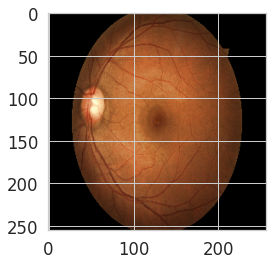

In [4]:
plots.checking_tfrecords(config_paths)

#2. Feature Extraction 

This next part will read some of the images (saved as train*.tfrec) to train an image model used to predict the original target from the Kaggle Competition. 

Then, using the remaining images (extract*.tfrec), it will created a features.csv file under the 'output' folder, which contain the features used to create the simulations. 

In [5]:
#2)Extracting features: it creates a new csv file called features.csv
with open(os.path.join(path_config, 'feature_extractor_setup.yaml')) as f:
      config_fe = yaml.safe_load(f)
config_fe = config_fe['parameters']

config_fe = utils.adding_paths_to_config(config_fe, config_paths)
config_fe['path_tfrecords'] = os.path.join(config_fe['path_root'], config_fe['path_tfrecords'])
config_fe['path_features'] = os.path.join(config_fe['path_root'], config_fe['path_features'])


if debuging:
  config_fe['epochs'] = 1
  config_fe['steps_per_epoch'] = 1

model = fe.extract_hx(config_fe)

['/content/drive/MyDrive/ColabNotebooks/data/testing/train00-4.tfrec']
['/content/drive/MyDrive/ColabNotebooks/data/testing/extract00-6.tfrec']
87924736/87910968 [==============================] - 0s 0us/step
No LR schedule provided. Using a fixed LR of "0.0001".
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 dense (Dense)               (None, 6, 6, 64)          131136    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 11525     
                                                                 
Total params: 21,945,445
Trainable params: 21,911,013
No

# 3. Data Simulations

The Feature Extraction phase produces a features.csv file, used to generate the data simulations. As we do not have any other features to use besides the outcome on the EyePACS dataset, we will adopt ICETEA light. 

Below, you can control the knobs. The knobs control the scale of treatment effect, the heterogeneity, and overlap. Default values are also provided.


All the simulations are merged under joined_simulations.csv, and true_tau.csv contains true values. Then, we join the joined_simulations.csv file with the 
tfrecrods (features/extract*.tfrec). The files saved in this step make the dataset used to train the causal inference models.


In [6]:
#3) Creates the simulations - first reads the saved csv file with the features extracted 
with open(os.path.join(path_config, 'data_simulation_setup.yaml')) as f:
      config_ds = yaml.safe_load(f)
config_ds = config_ds['parameters']
config_ds = utils.adding_paths_to_config(config_ds, config_paths)
config_ds['path_features'] = os.path.join(config_ds['path_root'], config_ds['path_features'])

ds.data_simulation_wrapper(config=config_ds)

simulations 6 (6, 81)
tfrecord_input_filenames ['/content/drive/MyDrive/ColabNotebooks/data/testing/extract00-6.tfrec']
DONE with JOIN features


## Seed naming convention

In order to save on space, the joined tfrecords on the folder ```path_tfrecords_new``` contains all the datasets simulated. 
This means that the covariates are always the same - but the treatments and outcomes are different, and they depend on the knobs and random initialization of the weights.

Hence, to properly load the dataset for the causal inference analysis, it is required to pass the dataset seed, aka, its unique identifier. 

The seed/id contains info about knobs adopted, repetition, and setting. See below the description:

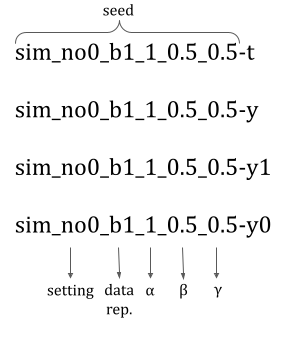

- data rep.: related to n_simulations. It ranges from b0 to b(n_simulations). 

- setting: it is related to the knob. 
  - no: no knob (fix α, β, and 𝝲); 
  - ko: overlap knob; 
  - kh: heterogeneity knob; 
  - ks: treat. effect scale knob.

- α: treatment effect knob
- β: overlap knob
- 𝝲: heterogeneity knob

The suffixes means: 
- t: treatment  assignment
- y: obsereved outcome
- y1: outcome if treated
- y0: outcome if control


Illustration:

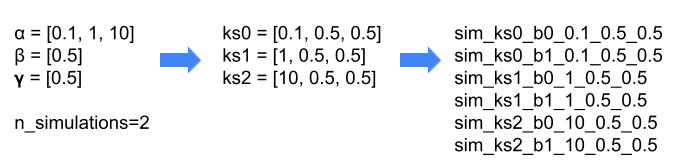





The code below double-check if the images were saved properly. You shold see an image after running the next cell. 

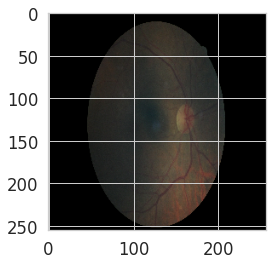

In [7]:
plots.checking_tfrecords_after_join(config=config_ds)